In [1]:


# VGG
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_ENABLE_CUDNN_OPTS'] = '1'
os.environ['DEEPREG_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
import tensorflow as tf
# for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
import matplotlib.pyplot as plt


In [2]:
# initial parameters for image_dataset_from_directory()
path = 'data/natural_images'
batch_size = None
WIDTH, HEIGHT = 224, 224 

In [3]:
# image_dataset_from_directory() method loads the data
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=path,             # defines the path to the data
    labels='inferred',          # 'inferred' - labels are generated from the directory structure
    label_mode='categorical',   # 'categoric' - labels are encoded as a categorical vector
    color_mode= 'rgb',          # 'grayscale', 'rgb', 'rgba' - images will be converted to have 1, 3 or 4 channels.
    batch_size=batch_size,      #  batch size
    image_size=(WIDTH, HEIGHT), # output size of images width and height
    shuffle=True,               # True - shuffle data, False - dates are arranged in alphabetical order
    seed=1234,                  # mixing ratio
    validation_split=0.2,       # splits data into training data and validation data
    subset='both',              #  is only used if set validation_split. 'both' - returns training and validation data
    crop_to_aspect_ratio=False, # cuts only elements that do not fall within the defined WIDTH/HEIGHT ratio
    pad_to_aspect_ratio=True,   # add value 0 on height or width to keep the defined ratio WIDTH/HEIGHT
    verbose=True)               # displays numerical information about classes and the number of files found

Found 6899 files belonging to 8 classes.
Using 5520 files for training.
Using 1379 files for validation.


In [4]:
# returns the class names and the number of directories
names_class = train_dataset.class_names
print('lista de clase : ', list(names_class))
dim_label = len(names_class)
print('numarul de clase : ', dim_label)

lista de clase :  ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
numarul de clase :  8


In [5]:
# normalize and create batches
batch_size = 32

def normalization(x, y): 
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.float32) 
    return x, y 

# use the .map() method in tf.data.Dataset to transform the elements
train_dataset = train_dataset.map(normalization).batch(batch_size) 
val_dataset = val_dataset.map(normalization).batch(batch_size)

In [6]:
# create test data set
    # normally this dataset is taken from the dataset and is different from the validation or training dataset !!!
    # The method below was created to extract each image separately for individual testing

# predefined lists
test_dataset_x = []
test_dataset_y = []

for x, y in val_dataset:                  # separates the data packets input data (x) and labels (y)
                                            
    for xx in x:                          # iterate the dataset x and add each return (xx) to test_dataset_x (iterations = batch_size)
        test_dataset_x.append(xx.numpy())
        
    for yy in y:                          # iterate the dataset y and add each return (yy) to test_dataset_y (iterations = batch_size)
        test_dataset_y.append(yy.numpy())

# converteste listele în array 
test_dataset_x = np.array(test_dataset_x)
test_dataset_y = np.array(test_dataset_y)

print(test_dataset_x.shape)
print(test_dataset_y.shape)

(1379, 224, 224, 3)
(1379, 8)


In [7]:
# Configuring the dataset for better performance

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# creating trainable coefficients for the first convolutional layer

# extract the number of color channels for the image used (RGB in this case)
dim_color_mode = test_dataset_x.shape[3]
print('number of image channels :', dim_color_mode)

# defines the filter size [height, width, in_channels, out_channels]
filters_conv1 = [7, 7, dim_color_mode, 8] 

# randomly generates the matrix described above (filters_conv1)
W_conv1 = tf.Variable(tf.random.truncated_normal(filters_conv1, stddev=0.1, seed=0))
# results in the size of the randomly generated 4-dimensional coefficient matrix
# i.e. 8 matrices with 3 dimensions in case of RGB images (or with 1 dimension in case of monochrome images)
# finally the matrix with 2 dimensions, in this case 7X7, moving on the image surface (generally 3X3 is used) 
print('W_conv1 : ', W_conv1.shape)

# generate the bias vector
b_conv1 = tf.Variable(tf.constant(0.1, shape=[8])) # need 8 biases for 8 outputs
print('b_conv1 : ', b_conv1.shape)

number of image channels : 3
W_conv1 :  (7, 7, 3, 8)
b_conv1 :  (8,)


In [9]:
# Convolutional 1
# strides=[batch, height, width, channels] - defines the sliding window pitch for each dimension
# padding="SAME" or "VALID" defines how to move the 7x7 window (in this case) to the edge of the images
# "VALID""SAME" - the edge of the 7x7 matrix does not exceed the edge of the matrix on which it is moving
# "SAME" - the center of the 7x7 matrix is at the edge of the matrix on which it moves

def convolve_1(x):
    return tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1

print(convolve_1(test_dataset_x).shape)

(1379, 224, 224, 8)


In [10]:
# activate 1

# the activation function is applied on the resulting matrices
def activate_1(x): 
    return tf.nn.relu(convolve_1(x))

print(activate_1(test_dataset_x).shape)

(1379, 224, 224, 8)


In [11]:
# pool 1

# pooling is a top-down sampling method that drags a window (e.g. 2x2) over the map
# input characteristics and extracts a value (max, min, average) from each window.

# ksize=[batch, height, width, channels] - defines the size of the window from which to extract the max_pool, in this case 2x2
# strides=[batch, height, width, channels] - defines the displacement step, in this case 2x2, which increases image resolution 
# (X, 224, 224, 8) -> (X, 112, 112, 8)

def pool_1(x):
    return tf.nn.max_pool(activate_1(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
print(pool_1(test_dataset_x).shape)

(1379, 112, 112, 8)


In [12]:
# creating trainable coefficients for the second convolutional layer

# The trainable coefficients are defined as 16 Maps (for output)
# 8 x 5x5 2D matrices
# 8 matrices are related to the number of filters entering the convolution

W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 8, 16], stddev=0.1, seed=0))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[16])) # 32 biases for outputs

print(W_conv2.shape)
print(b_conv2.shape)

(5, 5, 8, 16)
(16,)


In [13]:
# Convolutional 2

def convolve_2(x):
    return(tf.nn.conv2d(pool_1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

print(convolve_2(test_dataset_x).shape)

(1379, 112, 112, 16)


In [14]:
# activate 2
def activate_2(x): 
    return tf.nn.relu(convolve_2(x))

print(activate_2(test_dataset_x).shape)

(1379, 112, 112, 16)


In [15]:
# pool 2

def pool_2(x):
    return tf.nn.max_pool(activate_2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool_2(test_dataset_x).shape)

(1379, 56, 56, 16)


In [16]:
# creating trainable coefficients for the third convolutional layer

W_conv3 = tf.Variable(tf.random.truncated_normal([3, 3, 16, 32], stddev=0.1, seed=0))
b_conv3 = tf.Variable(tf.constant(0.1, shape=[32])) 

print(W_conv3.shape)
print(b_conv3.shape)

(3, 3, 16, 32)
(32,)


In [17]:
# Convolutional 3
def convolve_3(x):
    return(tf.nn.conv2d(pool_2(x), W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3)

print(convolve_3(test_dataset_x).shape)

(1379, 56, 56, 32)


In [18]:
# activate 3
def activate_3(x): 
    return tf.nn.relu(convolve_3(x))

print(activate_3(test_dataset_x).shape)

(1379, 56, 56, 32)


In [19]:
# pool 3
def pool_3(x):
    return tf.nn.max_pool(activate_3(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
print(pool_3(test_dataset_x).shape)

(1379, 28, 28, 32)


In [20]:
# in order to transfer the information from the last convolutional layer to the multilayer perceptrons it is necessary to transform the datalot
# so the 32 matrices of 28x28 are transformed into a one-dimensional matrix of 25088
# dim_flat = 32x28x28

dim_flat = pool_3(test_dataset_x).shape[1] * pool_3(test_dataset_x).shape[2] * pool_3(test_dataset_x).shape[3]
print(dim_flat)

25088


In [21]:
# the 'reshape' method is used to transform the data (-1 - that parameter remains unchanged)

def matrix_to_flat(x): 
    return tf.reshape(pool_3(x), [-1, dim_flat])

print(matrix_to_flat(test_dataset_x).shape)

(1379, 25088)


In [22]:
# creating coefficients for the first layer Fully-Connected (multilayer perceptrons)
# in this case create a matrix of (25088 x 4096) = (input size x number of outputs)

W_fc_1 = tf.Variable(tf.random.truncated_normal([dim_flat, 4096], stddev=0.1, seed = 2))
b_fc_1 = tf.Variable(tf.constant(0.1, shape=[4096])) # need 4096 biases for 4096 outputs

In [23]:
# Matrix Multiplication (applying weights and biases)

def fc_mul_1(x): 
    return tf.matmul(matrix_to_flat(x), W_fc_1) + b_fc_1

print(fc_mul_1(test_dataset_x).shape)

(1379, 4096)


In [24]:
# activate
def fc_act_1(x): 
    return tf.nn.relu(fc_mul_1(x))

In [25]:
# to combat over-fitting of the model, a method can be used to cancel some of the processed information
# the 'dropout' method, in this case cancel 50% of the data (keep_prob=0.5)

keep_prob=0.5
def layer_drop(x): 
    return tf.nn.dropout(fc_act_1(x), keep_prob)


In [26]:
# input size is equal to the output of the penultimate layer (4096)
# the output layer of the pattern the size corresponding to the labels (dim_label = 8)

W_fc_2 = tf.Variable(tf.random.truncated_normal([4096, dim_label], stddev=0.1, seed = 2))
b_fc_2 = tf.Variable(tf.constant(0.1, shape=[dim_label])) 

In [27]:
# Matrix Multiplication (applying weights and biases)

def fc_mul_2(x): 
    return tf.matmul(layer_drop(x), W_fc_2) + b_fc_2
    
print(fc_mul_2(test_dataset_x).shape)

(1379, 8)


In [28]:
# activate softmax
# The softmax function, also known as softargmax or normalized exponential function,
# converts a real vector into a probability distribution of possible outcomes.
# in this case it is used to normalize the output of a network to a probability distribution over the predicted output classes.

def out_model(x): 
    return tf.nn.softmax(fc_mul_2(x))

# as can be seen below, the sum of the 1D matrix approaches 1, and the number of elements is equal to the size of the labels

final_out = out_model(test_dataset_x)
print('primului rezultat softmax : ', final_out[0].numpy())
print()
print('suma primului rezultat : ',sum(final_out[0].numpy()))

primului rezultat softmax :  [1.0256758e-34 3.6072833e-03 9.9638391e-01 8.7760365e-23 1.2027346e-16
 6.4603505e-12 8.7652888e-06 1.9432839e-10]

suma primului rezultat :  0.9999999542467501


In [29]:
# The loss function, also called the error function, quantifies the difference between the results
# predicted results of a machine learning algorithm and the actual target values.
# y_true - true label
# y_pred - predicted label

def loss_value(y_true, y_pred):

    # mathematical function of the method 'categorical_crossentropy'
    # cce = y_true * tf.math.log(y_pred + 1.e-1000)
    # loss = -tf.reduce_sum(cce)
    
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    loss = tf.reduce_sum(cce)

    return loss

In [30]:
# Optimizers are algorithms or methods used to minimize an error (loss function) or maximize efficiency.
# Mathematical functions depend on the trainable parameters of the model, i.e. weights and errors.
# They help to modify the weights and learning rate of the neural network to minimize losses.

optimizer = tf.keras.optimizers.Adam(0.000001) # experimental sa rata de invatare 0.0001

In [31]:
# defining a list of model weights (trainable variables)
variables = [ W_conv1, b_conv1, W_conv2, b_conv2, W_conv3, b_conv3,
              W_fc_1, b_fc_1, W_fc_2, b_fc_2 ]

In [32]:

# create the implementation step for the correction of coefficients
def train_step(x, y):

    # class GradientTape() keeps track of the relevant operations executed within a tf.GradientTape instance
    with tf.GradientTape() as tape:
        # via the loss flap returns the amount of the loss
        current_loss = loss_value( y, out_model( x ))

    # create the gradient to change the weighting of the current value of the losses     
    grads = tape.gradient( current_loss , variables )

    # apply the gradient change on the current weighting state
    optimizer.apply_gradients( zip( grads , variables ) )
    
    return current_loss.numpy()

In [33]:
# Metrics quantify the quality of predictions made by machine learning models.
# They provide useful information for evaluating, comparing and improving models.

def metric(y_true, y_pred):

    # mathematical expression of the method 'CategoricalAccuracy'
    # correct_prediction = tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(y_true, axis=1))
    # metric = -tf.reduce_mean(correct_prediction)

    metric_acu = tf.keras.metrics.CategoricalAccuracy()
    metric = metric_acu(y_true, y_pred)
    metric = tf.reduce_mean(metric)

    return metric.numpy() 
    

In [34]:



epochs = 50

# defines the list of loss values
train_loss=[]
val_loss=[]

# defines the list of accuracy volumes 
train_accuracies=[]
val_accuracies=[]


# define the learning loop function
for i in range(epochs):

    # printeaza epoca curenta
    print("epoch ", str(i))

    # defines the list of packet loss values in the current epoch 
    batch_loss_train = []
    # defines the list of current era packet accuracy volumes
    batch_accuracies_train = []

    # iterates training data packages
    for x_train_batch, y_train_batch in train_dataset:

        # add the entropy value to the list
        batch_loss_train.append(train_step(x_train_batch, y_train_batch)) # by launching the train_step() function
        # add the metric value to the list
        batch_accuracies_train.append(metric(y_train_batch, out_model(x_train_batch)))#  by launching the metric() function

    # average the results and add the average per epoch to the final list
    train_loss.append(np.mean(batch_loss_train))
    train_accuracies.append(np.mean(batch_accuracies_train))

    # print accuracy on each epoch
    print("accuracy of entire train_set", str(np.mean(batch_accuracies_train))) 


    # for validation data, the description is similar to the description mentioned above
    
    batch_accuracies_val=[]
    batch_loss_val = []
    for x_val_batch, y_val_batch in val_dataset:
        
        batch_accuracies_val.append(metric(y_val_batch, out_model(x_val_batch)))

        batch_loss_val.append(loss_value(y_val_batch, out_model(x_val_batch)))
        
    val_accuracies.append(np.mean(batch_accuracies_val))
    val_loss.append(np.mean(batch_loss_val))
        
    print("accuracy of entire val_set", str(np.mean(batch_accuracies_val)))  




epoch  0
accuracy of entire train_set 0.12572254
accuracy of entire val_set 0.13612689
epoch  1
accuracy of entire train_set 0.1466763
accuracy of entire val_set 0.13707386
epoch  2
accuracy of entire train_set 0.16871387
accuracy of entire val_set 0.18323864
epoch  3
accuracy of entire train_set 0.22543353
accuracy of entire val_set 0.26964962
epoch  4
accuracy of entire train_set 0.29624277
accuracy of entire val_set 0.33214962
epoch  5
accuracy of entire train_set 0.34302744
accuracy of entire val_set 0.35748106
epoch  6
accuracy of entire train_set 0.38421243
accuracy of entire val_set 0.4067235
epoch  7
accuracy of entire train_set 0.4132948
accuracy of entire val_set 0.4280303
epoch  8
accuracy of entire train_set 0.44671243
accuracy of entire val_set 0.45975378
epoch  9
accuracy of entire train_set 0.4642341
accuracy of entire val_set 0.4732481
epoch  10
accuracy of entire train_set 0.48970374
accuracy of entire val_set 0.4955019
epoch  11
accuracy of entire train_set 0.5045159


<function matplotlib.pyplot.show(close=None, block=None)>

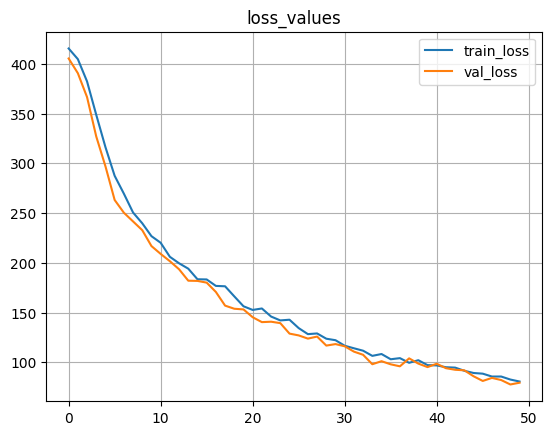

In [35]:
# presentation of graphs showing the evolution of 'loss' losses in relation to the period
plt.figure(1)
plt.plot(train_loss, label = 'train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.title('loss_values')
plt.legend() 
plt.grid()
plt.show

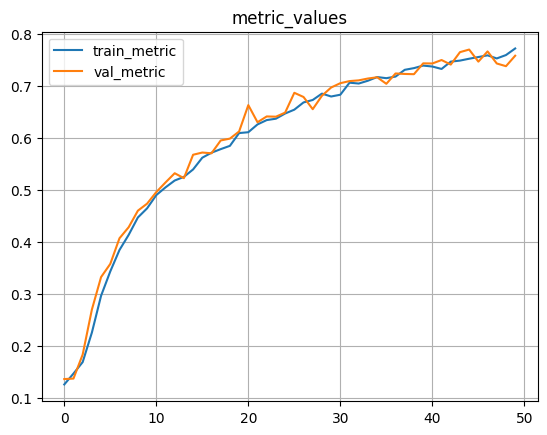

In [36]:
# presentation of the evolution graphs of the 'metrics' indicator in relation to the period
plt.figure(2)
plt.plot(train_accuracies, label = 'train_metric')
plt.plot(val_accuracies, label = 'val_metric')
plt.title('metric_values')
plt.legend() 
plt.grid()
plt.show()

In [37]:
# creating the confusion matrix

# indicate the position of the maximum value on each row (axis = 1 set 'argmax' to analyze per column)
pred = tf.argmax(out_model( test_dataset_x), axis = 1)
label = tf.argmax(test_dataset_y, axis = 1)

# creates the confusion matrix
cm = tf.math.confusion_matrix(label, pred)

# create data frame in pandas
cm_df = pd.DataFrame(cm, index = names_class, columns = names_class)
print(cm_df)

           airplane  car  cat  dog  flower  fruit  motorbike  person
airplane        142    0    2    1       2      0          2       0
car               0  162    9    4       8      1          1       3
cat               1   11   99   42      14      1          7       7
dog               0    2   65   31       8      4          7       7
flower            3    8   30   20     119      0         13       3
fruit             0    3    0    0       0    200          0       0
motorbike         1    0    5    0       5      0        143       0
person            1    7    2    7       1      2          0     163


In [38]:
# generates the resulting image on each stage of the convolutional networks
# in this case only the first 50
img1 = convolve_1(test_dataset_x[0:50])
img2 = activate_1(test_dataset_x[0:50])
img3 = pool_1(test_dataset_x[0:50])

img4 = convolve_2(test_dataset_x[0:50])
img5 = activate_2(test_dataset_x[0:50])
img6 = pool_2(test_dataset_x[0:50])

img7 = convolve_3(test_dataset_x[0:50])
img8 = activate_3(test_dataset_x[0:50])
img9 = pool_3(test_dataset_x[0:50])

original image


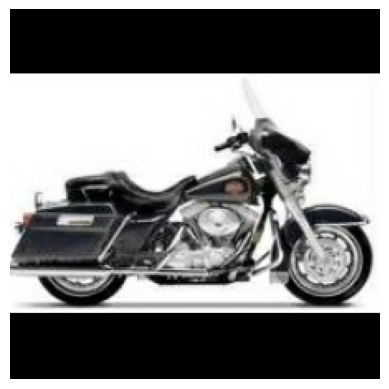

In [39]:
# original image
nr_im = 1 # 0:49

print('original image')
plt.imshow(test_dataset_x[nr_im])
plt.axis('off')
plt.savefig("imaginea_originala.jpg")
plt.show()
print('=========================================================================================')

Convolutional 1  (224, 224, 8)


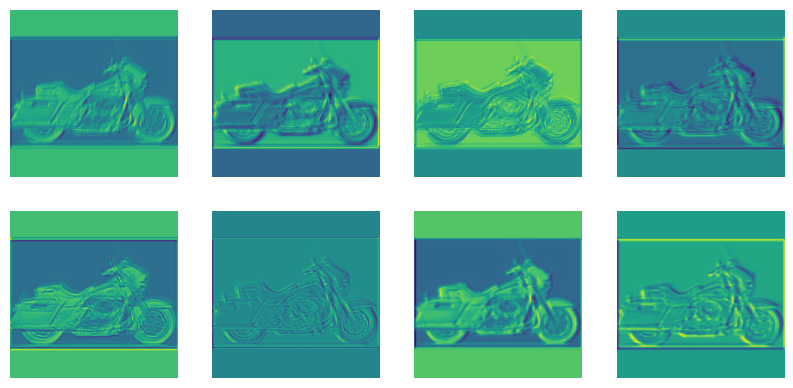

activate 1  (224, 224, 8)


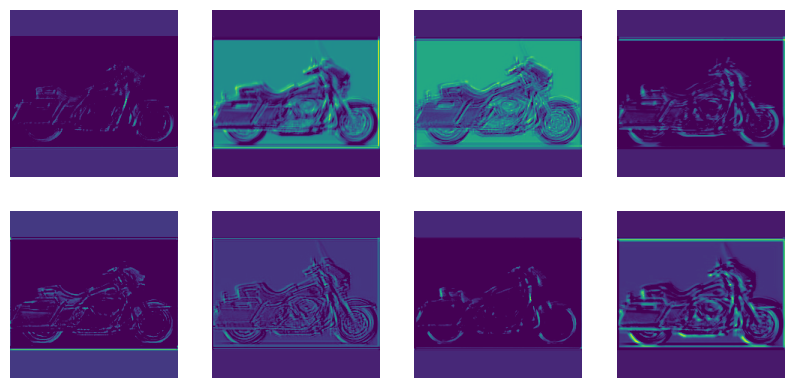

pool 1  (112, 112, 8)


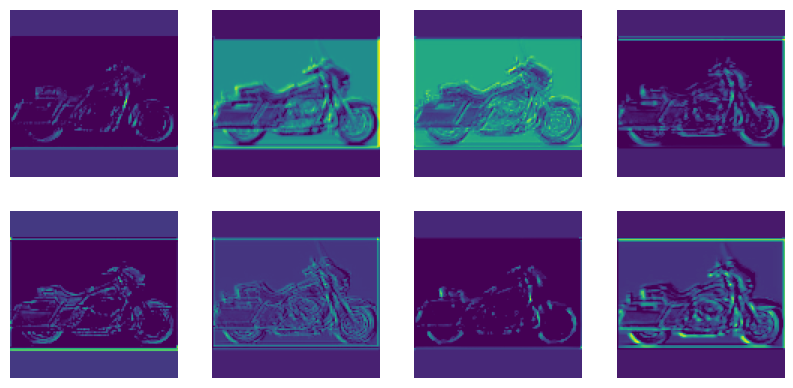

In [40]:
# plotting the resulting images


nr_im = 1 # 0:49


print('Convolutional 1 ', img1[nr_im].shape)

plt.figure(3,figsize=(10,10))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.imshow(img1[nr_im,:,:,i])
    plt.axis('off')
plt.savefig("convolutie 1.jpg")
plt.show()
print('=========================================================================================')
print('activate 1 ', img2[nr_im].shape)
plt.figure(4,figsize=(10,10))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.imshow(img2[nr_im,:,:,i])
    plt.axis('off')
plt.savefig("activate 1.jpg")
plt.show()
print('=========================================================================================')
print('pool 1 ', img3[nr_im].shape)
plt.figure(5,figsize=(10,10))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.imshow(img3[nr_im,:,:,i])
    plt.axis('off')
plt.savefig("pool 1.jpg")
plt.show()

Convolutional 2  (112, 112, 16)


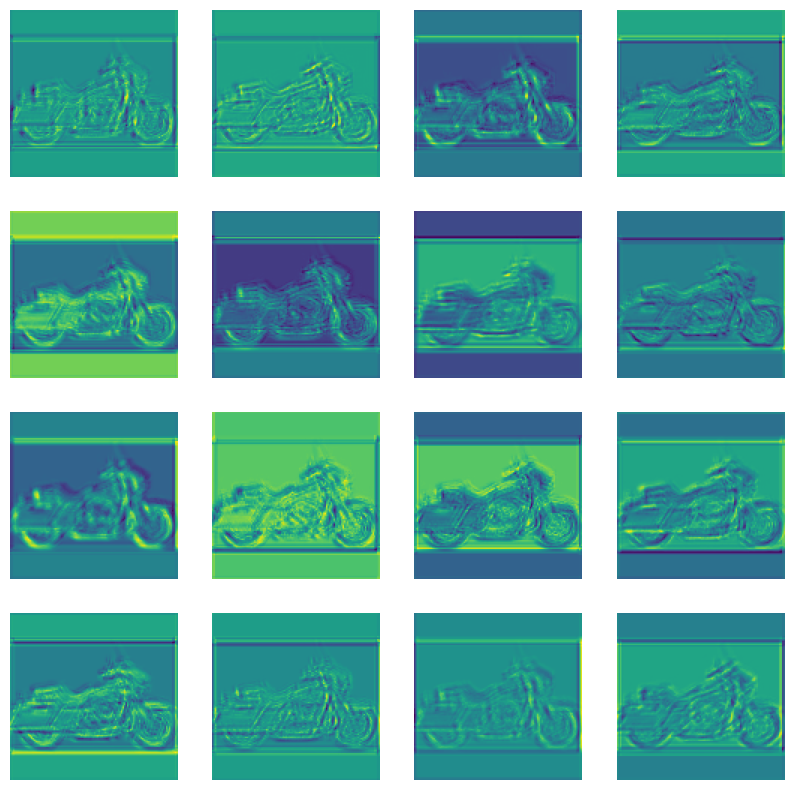

activate 2  (112, 112, 16)


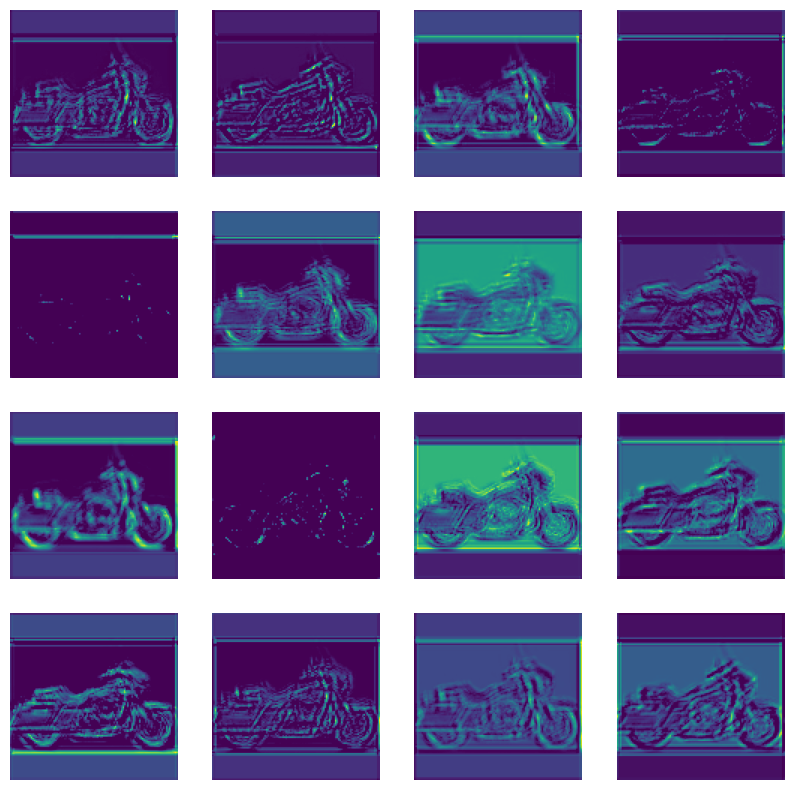

pool 2  (56, 56, 16)


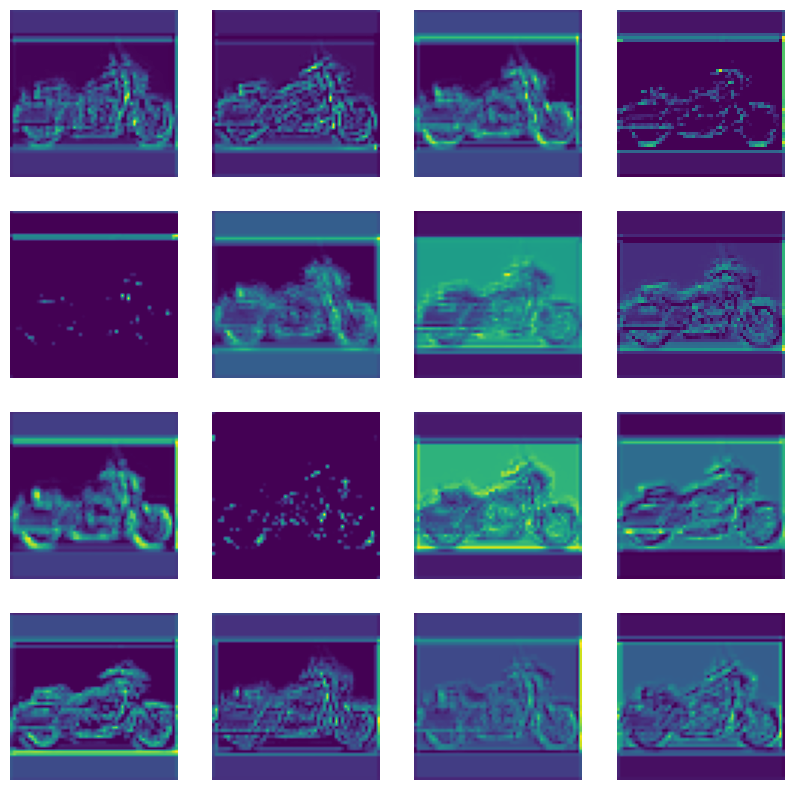

In [41]:
print('Convolutional 2 ', img4[nr_im].shape)

plt.figure(6,figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(img4[nr_im,:,:,i])
    plt.axis('off')
plt.savefig("convolutie 2.jpg")
plt.show()
print('=========================================================================================')
print('activate 2 ', img4[nr_im].shape)
plt.figure(7,figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(img5[nr_im,:,:,i])
    plt.axis('off')
plt.savefig("activate 2.jpg")
plt.show()
print('=========================================================================================')
print('pool 2 ', img6[nr_im].shape)
plt.figure(8,figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(img6[nr_im,:,:,i])
    plt.axis('off')
plt.savefig("pool 2.jpg")
plt.show()

Convolutional 3  (56, 56, 32)


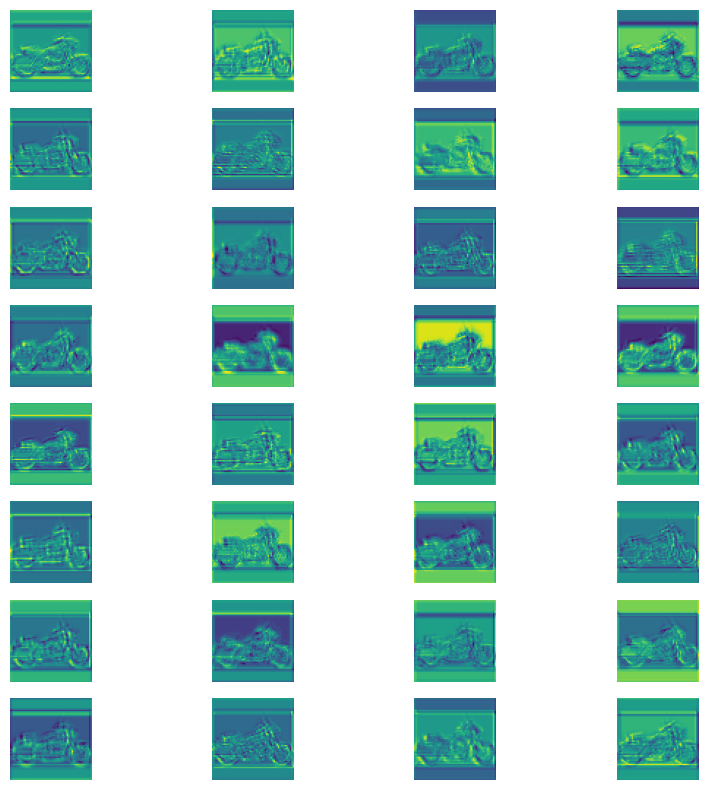

activate 3  (56, 56, 32)


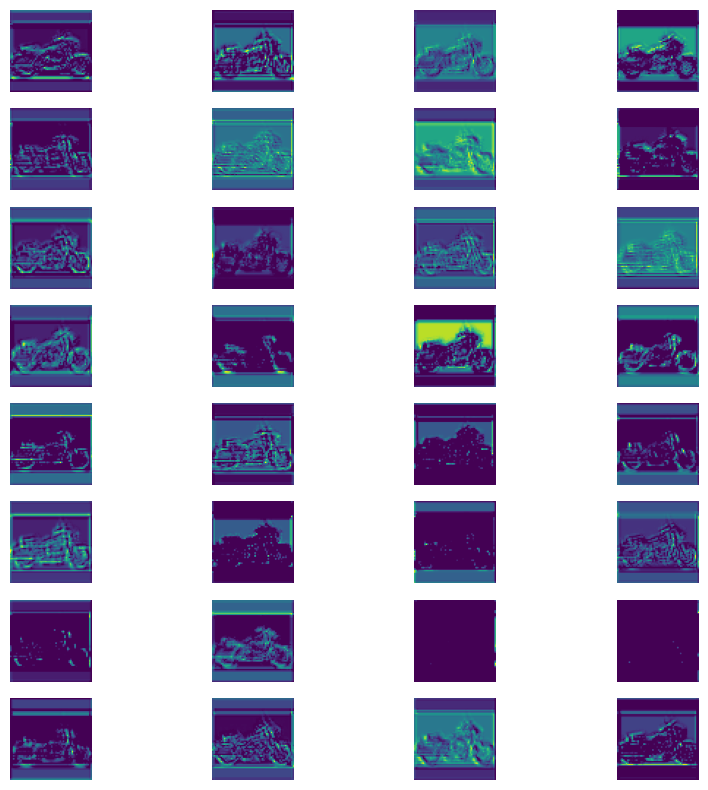

pool 3  (28, 28, 32)


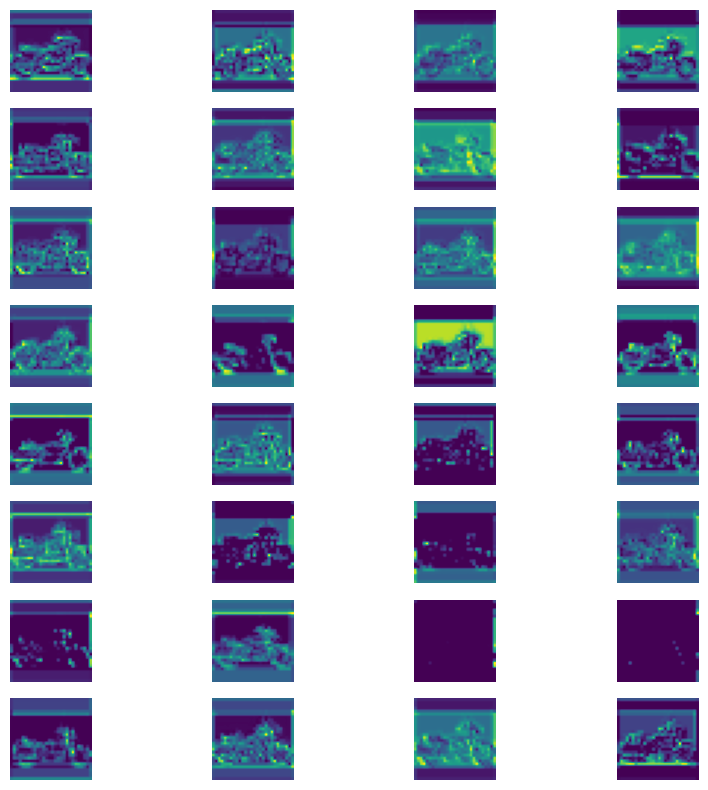

In [42]:
print('Convolutional 3 ', img7[nr_im].shape)
plt.figure(9,figsize=(10,10))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(img7[nr_im,:,:,i])
    plt.axis('off')
plt.savefig("convolutie 3.jpg")
plt.show()
print('=========================================================================================')
print('activate 3 ', img8[nr_im].shape)
plt.figure(10,figsize=(10,10))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(img8[nr_im,:,:,i])
    plt.axis('off')
plt.savefig("activate 3.jpg")
plt.show()
print('=========================================================================================')
print('pool 3 ', img9[nr_im].shape)
plt.figure(11,figsize=(10,10))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(img9[nr_im,:,:,i])
    plt.axis('off')
plt.savefig("pool 3.jpg")
plt.show()